In [1]:
#Importing the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pickle 
import gym

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as func
import torch.distributions as dist

In [2]:
# Actor Neural Network model
class Actor(nn.Module):
    """
    Actor network for PPO.
    Args:
        i_dim (int): Input dimension (number of state features)
        o_dim (int): Output dimension (number of actions)
        h_dim (int): Hidden layer dimension
    """

    def __init__(self, i_dim, o_dim, h_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(i_dim, h_dim),
            nn.Dropout(p=0.16),  # Dropout layer with probability 0.16
            nn.PReLU(),  # Parametric Rectified Linear Unit activation function
            nn.Linear(h_dim, o_dim),
            nn.Softmax(dim=-1)  # Softmax activation function for output probability distribution
        )

    def forward(self, x):
        """
        Forward pass of the Actor network.
        Args:
            x (torch.Tensor): Input state tensor
        Returns:
            torch.Tensor: Output probability distribution over actions
        """
        return self.net(x)


# Critic Neural Network model
class Critic(nn.Module):
    """
    Critic network for PPO.
    Args:
        i_dim (int): Input dimension (number of state and action features)
        h_dim (int): Hidden layer dimension
    """

    def __init__(self, i_dim, h_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(i_dim, h_dim),
            nn.Dropout(p=0.16),  # Dropout layer with probability 0.16
            nn.PReLU(),  # Parametric Rectified Linear Unit activation function
            nn.Linear(h_dim, 1)  # Output layer with single value
        )

    def forward(self, x):
        """
        Forward pass of the Critic network.
        Args:
            x (torch.Tensor): Input state and action tensor
        Returns:
            torch.Tensor: Output estimated value
        """
        return self.net(x)

In [3]:
# Create the training environment
Train_envir = gym.make('LunarLander-v2')

# Get the input dimension from the environment's observation space
I_DIM = Train_envir.observation_space.shape[0]

# Set the hidden layer dimension
H_DIM = 128

# Get the output dimension from the environment's action space
O_DIM = Train_envir.action_space.n

# Create the Actor network
Actor_ = Actor(I_DIM, O_DIM, H_DIM)

# Create the optimizer for the Actor network
Opt_Actor = optim.Adam(Actor_.parameters())

# Create the Critic network
Critic_ = Critic(I_DIM, H_DIM)

# Create the optimizer for the Critic network
Opt_Critic = optim.Adam(Critic_.parameters())

In [4]:
MAX_EPISODES = 2000  # The maximum number of episodes for agent-environment interaction
DISCOUNT_FACTOR = 0.99  # Discount factor to weigh future rewards compared to immediate rewards
EPSILON_DECAY = 0.3  # Rate at which the exploration factor (epsilon) decreases over time
PPO_STEPS = 7  # Number of iterations for PPO algorithm
REWARD_THRESHOLD = 200  # Desired level of success in the task

In [ ]:
Rewards, Policy_Losses, Value_Losses, Mean_Rewards = [], [], [], []

# Loop over episodes
for epi in range(1, MAX_EPISODES + 1):
    States, Actions, Log_prob_actions, Values, rewards = [], [], [], [], []
    Done = False
    epi_reward = 0
    state, step = Train_envir.reset()

    # Episode loop
    while not Done:
        state = torch.FloatTensor(state).unsqueeze(0)
        States.append(state)
        
        Pred_action = Actor_(state)
        distri = dist.Categorical(Pred_action)
        Action = distri.sample()
        Log_prob_action = distri.log_prob(Action)

        Pred_Value = Critic_(state)
        
        state, reward, terminated, trunked, step = Train_envir.step(Action.item())
        if terminated or trunked:
            Done = True
        else:
            Done = False
        
        Actions.append(Action)
        Log_prob_actions.append(Log_prob_action)
        Values.append(Pred_Value)
        rewards.append(reward)
        
        epi_reward += reward

    Returns, Advantage = [], 0
    for r in reversed(rewards):
        Advantage = r + Advantage * DISCOUNT_FACTOR
        Returns.insert(0, Advantage)       
    Returns = torch.tensor(Returns)
    Returns = (Returns - Returns.mean()) / Returns.std()
    
    Values = torch.cat(Values).squeeze(-1)
    advantages = Returns - Values
    advantages = (advantages - advantages.mean()) / advantages.std()

    States = torch.cat(States)
    Actions = torch.cat(Actions)
    Log_prob_actions = torch.cat(Log_prob_actions).detach()
    advantages = advantages.detach()

    # PPO optimization loop
    for step in range(PPO_STEPS):

        Pred_action = Actor_(States)
        distri = dist.Categorical(Pred_action)
        new_log_prob_actions = distri.log_prob(Actions)
        policy_ratio = (new_log_prob_actions - Log_prob_actions).exp()
        
        policy_loss1 = policy_ratio * advantages
        policy_loss2 = torch.clamp(policy_ratio, min = 1.0 - EPSILON_DECAY, 
                                   max = 1.0 + EPSILON_DECAY) * advantages  
        Policy_loss = -torch.min(policy_loss1, policy_loss2).sum()
        Pred_Value = Critic_(States).squeeze(-1)
        Value_loss = func.smooth_l1_loss(Returns, Pred_Value).sum()
        
        Opt_Actor.zero_grad()
        Opt_Critic.zero_grad()     
        Policy_loss.backward()
        Value_loss.backward()      
        Opt_Actor.step()
        Opt_Critic.step()

    Rewards.append(epi_reward)
    Policy_Losses.append(Policy_loss.item())
    Value_Losses.append(Value_loss.item())
    
    # Calculate the mean reward over the last 100 episodes
    if len(Rewards) >= 100:
        Latest_100_Mean = sum(Rewards[-100:]) / 100
        Mean_Rewards.append(Latest_100_Mean)

        # Print episode information every 10 episodes
        if epi % 10 == 0:
            print(f'Episode {epi:3}:')
            print(f'Reward = {epi_reward}, Mean of last 100 episodes = {Latest_100_Mean}')

        # Break the training loop if the mean reward exceeds the threshold
        if Latest_100_Mean > REWARD_THRESHOLD:
            print(f"Stopped Training: Mean of last 100 episode rewards has exceeded 200 ({Latest_100_Mean})!")
            break

# Save the trained actor model
torch.save(Actor_.state_dict(), 'trained_actor_model.pth')

# Save rewards and losses to files
with open('Rewards.pkl', 'wb') as file:
    pickle.dump(Rewards, file)
with open('Policy_Losses.pkl', 'wb') as file:
    pickle.dump(Policy_Losses, file)
with open('Value_Losses.pkl', 'wb') as file:
    pickle.dump(Value_Losses, file)
with open('Mean_Rewards.pkl', 'wb') as file:
    pickle.dump(Mean_Rewards, file)


In [ ]:
import os
os.environ["IMAGEIO_FFMPEG_EXE"] = r"/Users/ishaankchopra/Downloads/ffmpeg"  # Set the path to the FFmpeg executable

from gym.wrappers.monitoring.video_recorder import VideoRecorder

# Load the trained actor model
Actor_ = Actor(I_DIM, O_DIM, H_DIM)
Actor_.load_state_dict(torch.load('trained_actor_model.pth'))
Actor_.eval()

# Create the test environment and video recorder
Test_envir = gym.make('LunarLander-v2', render_mode="rgb_array")
vid = VideoRecorder(Test_envir, path=f"LunarLander-v2.mp4")

TEST_EPISODES = 10
for epi in range(1, TEST_EPISODES + 1):
    state, step = Test_envir.reset()
    Done = False
    epi_reward = 0

    # Test episode loop
    while not Done:
        Test_envir.render()  # Render the environment
        vid.capture_frame()  # Capture a frame for video recording

        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            Action_probability = Actor_(state)
        distri = dist.Categorical(Action_probability)
        Action = distri.sample()

        state, reward, terminated, trunked, step = Test_envir.step(Action.item())
        if terminated or trunked:
            Done = True
        else:
            Done = False
        epi_reward += reward

    # Print test episode information
    print(f'Test Episode {epi}:')
    print(f'Total Reward = {epi_reward}')

vid.close()  # Close the video recorder
Test_envir.close()  # Close the test environment

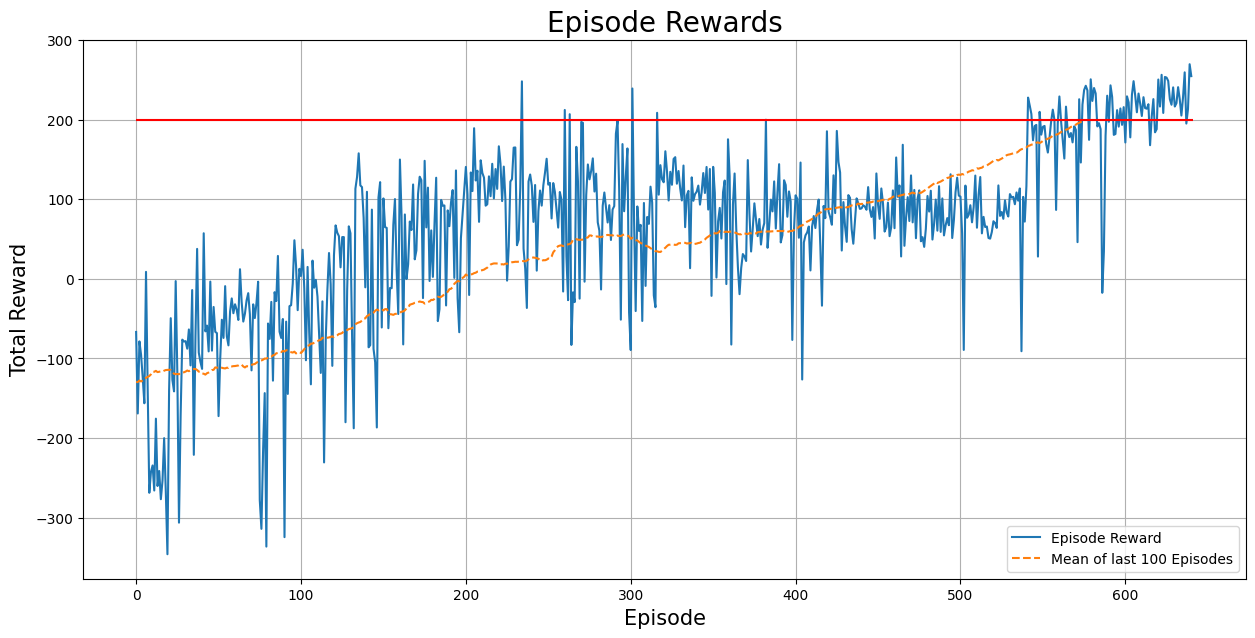

In [5]:
# Load rewards data from file
with open('Rewards.pkl', 'rb') as file:
    Rewards = pickle.load(file)
with open('Mean_Rewards.pkl', 'rb') as file:
    Mean_Rewards = pickle.load(file)

# Plotting the rewards
plt.figure(figsize=(15,7))  # Set the figure size
plt.plot(Rewards, label='Episode Reward')
plt.plot(Mean_Rewards, label='Mean of last 100 Episodes', linestyle='dashed')
plt.xlabel('Episode', fontsize=15)
plt.ylabel('Total Reward', fontsize=15)

# Add a red line at the reward threshold
plt.hlines(REWARD_THRESHOLD, 0, len(Rewards), color='r')

plt.legend(loc='lower right')
plt.title('Episode Rewards', fontsize=20)
plt.grid()

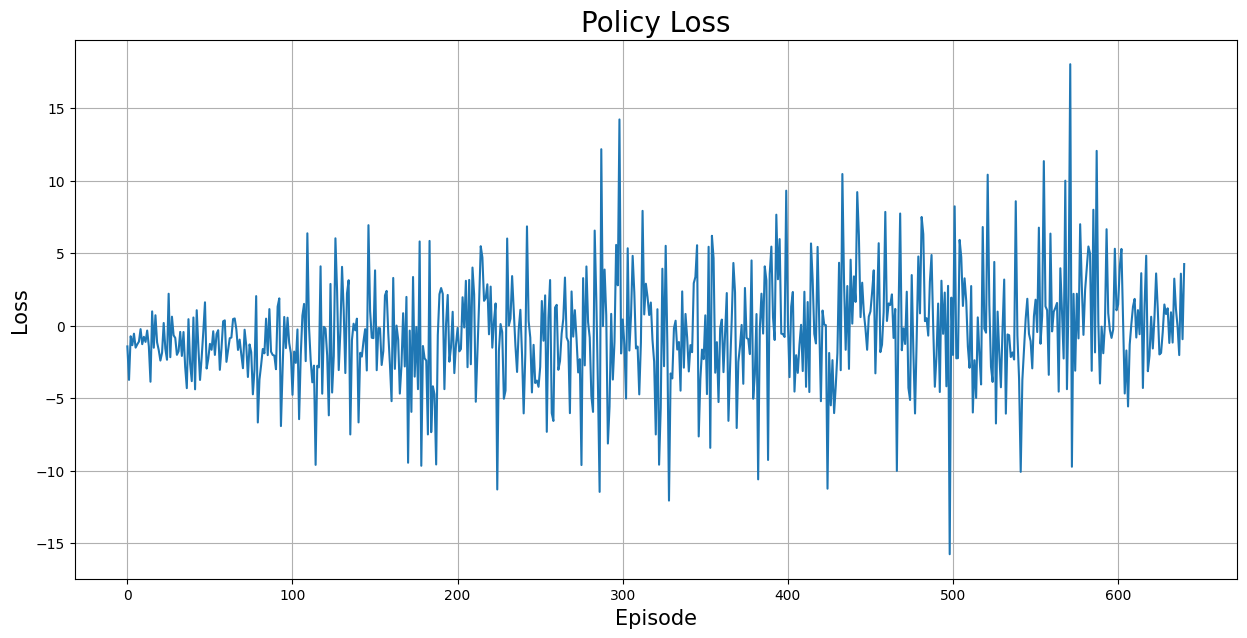

In [6]:
# Load policy loss history from file
with open('Policy_Losses.pkl', 'rb') as file:
    Policy_Losses = pickle.load(file)

# Plotting the policy loss history
plt.figure(figsize=(15,7))  # Set the figure size
plt.plot(Policy_Losses)
plt.xlabel('Episode', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.title('Policy Loss', fontsize=20)
plt.grid()

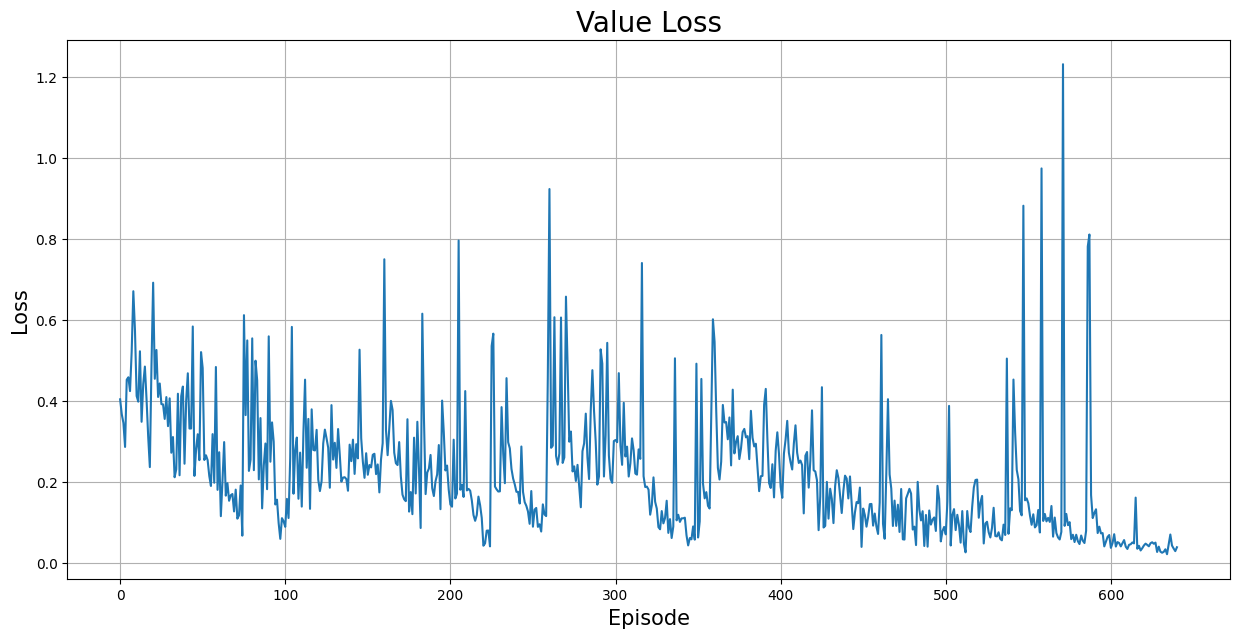

In [7]:
# Load value loss history from file
with open('Value_Losses.pkl', 'rb') as file:
    Value_Losses = pickle.load(file)

# Plotting the value loss history
plt.figure(figsize=(15,7))
plt.plot(Value_Losses)
plt.xlabel('Episode', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.title('Value Loss', fontsize=20)
plt.grid()